# Course 2: Advanced Portfolio Construction and Analysis With Python
## Module 2: Robust Estimates for the Covariance Matrix


**Question 1**

Load the 30 Value Weighted industry portfolio returns. Limit the analysis to returns of the 30 VW portfolios from 1997 onwards (1997 included, 1996 not included, 2018 included). Also load the Market Caps of each of the 30 industries. Run a backtest of comparing a CapWeighted vs an EW portfolio over the period. Though these two weighting schemes do not need any estimation, use an estimation period of 36 months so that we can compare it in the next few questions.

What was the annualized return over period for the Cap Weighted Industry Portfolio?

Enter the answer as a percentage (e.g. for a return of 5.67% enter 5.67)

In [1]:
import pandas as pd
import numpy as np

In [2]:
def get_ind_file(filetype, weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios files
    Variant is a tuple of (weighting, size) where:
        weighting is one of "ew", "vw"
        number of inds is 30 or 49
    """    
    if filetype is "returns":
        name = f"{weighting}_rets" 
        divisor = 100
    elif filetype is "nfirms":
        name = "nfirms"
        divisor = 1
    elif filetype is "size":
        name = "size"
        divisor = 1
    else:
        raise ValueError(f"filetype must be one of: returns, nfirms, size")
    
    ind = pd.read_csv(f"data/ind{n_inds}_m_{name}.csv", header=0, index_col=0, na_values=-99.99)/divisor
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_market_caps(n_inds=30, weights=False):
    """
    Load the industry portfolio data and derive the market caps
    """
    ind_nfirms = get_ind_file('nfirms', n_inds=n_inds)
    ind_size =get_ind_file('size', n_inds=n_inds)
    ind_mktcap = ind_nfirms * ind_size
    if weights:
        total_mktcap = ind_mktcap.sum(axis=1)
        ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
        return ind_capweight
    return ind_mktcap

#Load the 30 Value Weighted industry portfolio returns & market cap from 1997 onwards
ind_returns =  get_ind_file('returns', 'vw', n_inds=30).loc['1997':'2018', :]
ind_mcap = get_ind_market_caps(n_inds=30, weights=True).loc['1997':'2018', :]

In [3]:
def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted 
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        ## exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        #limit weight to a multiple of capweight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum() #reweight
    return ew

def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    w = cap_weights.loc[r.index[0]]
    return w/w.sum()

In [4]:
def backtest_ws(r, estimation_window=60, weighting=weight_ew, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert List of weights to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

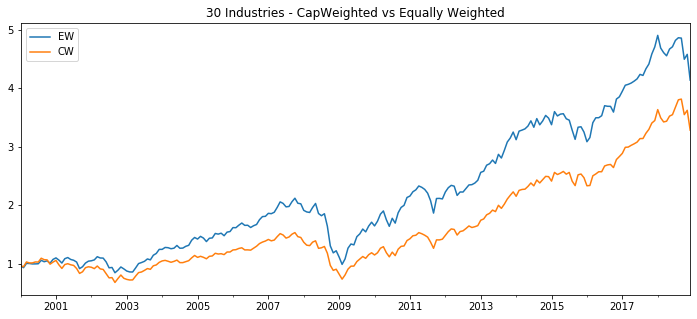

In [5]:
ewr = backtest_ws(ind_returns, estimation_window=36)
cwr = backtest_ws(ind_returns, weighting=weight_cw, cap_weights=ind_mcap, estimation_window=36)
backtest_df = pd.DataFrame({"EW": ewr, "CW": cwr})
backtest_df.dropna(inplace = True)
(1+backtest_df).cumprod().plot(figsize=(12,5), title="30 Industries - CapWeighted vs Equally Weighted")

In [6]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    """
    return r.std()*(periods_per_year**0.5)

In [7]:
round(annualize_rets(cwr.dropna(), periods_per_year=12)*100,2)

6.46

**Question 2**

Use the same data and period as the previous question.

What was the annualized volatility over the period for the Cap Weighted Industry Portfolio?

Enter the answer as a percentage (e.g. for a vol of 25.67% enter 25.67)

In [8]:
round(annualize_vol(cwr.dropna(), periods_per_year=12)*100,2)

15.13

**Question 3**

Use the same data and period as the previous question.

What was the annualized return over period for the Equal Weighted Industry Portfolio?

Enter the answer as a percentage (e.g. for a return of 5.67% enter 5.67)

In [9]:
round(annualize_rets(ewr.dropna(), periods_per_year=12)*100,2)

7.76

**Question 4**

Use the same data and period as the previous question.

What was the annualized volatility over the period for the Equal Weighted Industry Portfolio?

Enter the answer as a percentage (e.g. for a vol of 15.67% enter 15.67)

In [10]:
round(annualize_vol(ewr.dropna(), periods_per_year=12)*100,2)

15.87

**Question 5**

Now using the same data and same period, re-run the EW backtest but this time create a tethered EW portfolio by removing Microcap industries using a threshold of 1% and a max cap-weight multiple of 2X

What was the annualized return over the period for the tethered Equal Weighted Industry Portfolio?

Enter the answer as a percentage (e.g. for a return of 5.67% enter 5.67)


In [11]:
ewtr = backtest_ws(ind_returns, estimation_window=36, cap_weights=ind_mcap, max_cw_mult=2, microcap_threshold=.01)
round(annualize_rets(ewtr.dropna(), periods_per_year=12)*100,2)

7.68

**Question 6**

Use the same tethered EW portfolio (by removing Microcap industries using a threshold of 1% and a max cap-weight multiple of 2X) as in the previous question.

What was the annualized volatility over the period for the tethered Equal Weighted Industry Portfolio?

Enter the answer as a percentage (e.g. for a vol of 5.67% enter 5.67)

In [12]:
round(annualize_vol(ewtr.dropna(), periods_per_year=12)*100,2)

14.08

**Question 7**

What was Tracking Error between the Pure EW (without any tethering) portfolio and the CW portfolio?

Enter the answer as a percentage (e.g. for a Tracking Error of 5.67% enter 5.67)

In [13]:
def tracking_error(r_a, r_b):
    """
    Returns the Tracking Error between the two return series
    """
    return np.sqrt(((r_a - r_b)**2).sum())

In [14]:
(tracking_error(ewr.dropna(), cwr.dropna())*100).round(2)

18.74

**Question 8**

Now consider the Tethered EW portfolio you previously created (by removing Microcap industries using a threshold of 1% and a max cap-weight multiple of 2X)

What was Tracking Error between the Tethered EW portfolio and the CW portfolio?

Enter the answer as a percentage (e.g. for a Tracking Error of 5.67% enter 5.67)

In [15]:
(tracking_error(ewtr.dropna(), cwr.dropna())*100).round(2)

11.65

**Question 9**

Run a backtest for the same period (1997 onwards i.e. 1997 included, 1996 not included, 2018 included), using an estimation window of 36 months as above, to build the Global Minimum Variance Portfolio by estimating the Covariance matrix using Sample Covariance. (This might take a minute or so to run depending on your computer power!)

What was the annualized return over the period for the GMV Portfolio?

Enter the answer as a percentage (e.g. for a return of 5.67% enter 5.67)

In [16]:
def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return gmv(est_cov)

def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

from scipy.optimize import minimize
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    vol = (weights.T @ covmat @ weights)**0.5
    return vol 

In [17]:
gmv_port = backtest_ws(ind_returns, estimation_window=36, weighting=weight_gmv, cov_estimator=sample_cov)
gmv_port.dropna(inplace = True)

In [18]:
round(annualize_rets(gmv_port.dropna(), 12)*100,2)

6.63

**Question 10**

Use the same GMV portfolio as the previous question. What was the annualized volatility over the period for the GMV Portfolio?

Enter the answer as a percentage (e.g. for a vol of 5.67% enter 5.67)

In [19]:
round(annualize_vol(gmv_port.dropna(), 12)*100,2)

11.74

**Question 11**

Run a backtest for the same period as the previous question, and again using an estimation window of 36 months as above, to build the Global Minimum Variance Portfolio but this time, estimating the Covariance matrix using Shrinkage between the Constant 
Correlation and Sample Covariance estimates using a delta of 0.25. (This might take a minute or so to run depending on your computer power!)

What was the annualized return over the period for this new Shrinkage-GMV Portfolio?

Enter the answer as a percentage (e.g. for a return of 5.67% enter 5.67)

In [20]:
def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    return pd.DataFrame(ccor * np.outer(sd, sd), index=r.columns, columns=r.columns)

def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample

gmv_port_shr = backtest_ws(ind_returns, estimation_window=36, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.25)

In [21]:
round(annualize_rets(gmv_port_shr.dropna(), 12)*100,2)

6.85

**Question 12**

Using the same Shrinkage-GMV portfolio return series you used in the previous question, what was the annualized volatility over the period for the Shrinkage-GMV Portfolio?

Enter the answer as a percentage (e.g. for a vol of 5.67% enter 5.67)

In [22]:
round(annualize_vol(gmv_port_shr.dropna(), 12)*100,2)

11.46